#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

In [24]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

## Анализ

In [3]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


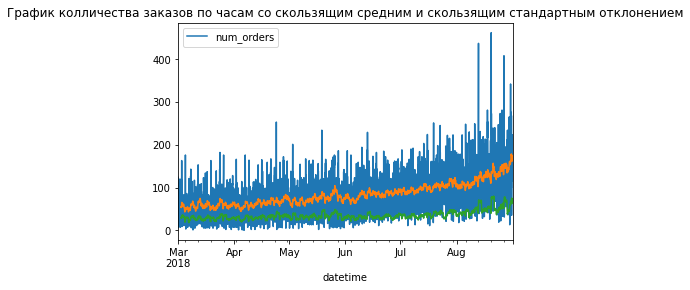

In [25]:
data.plot() 
data['num_orders'].rolling(40).mean().plot(title='График колличества заказов по часам со скользящим средним и скользящим стандартным отклонением')
data['num_orders'].rolling(40).std().plot()
plt.show()


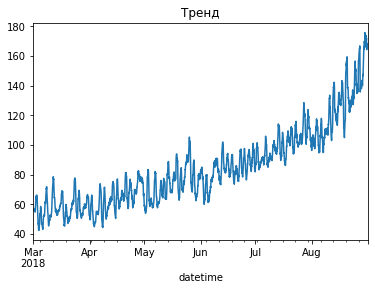

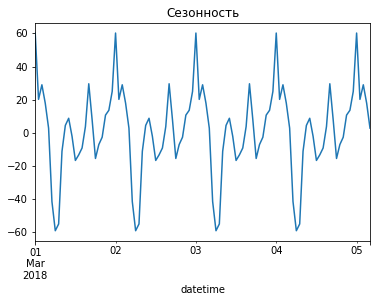

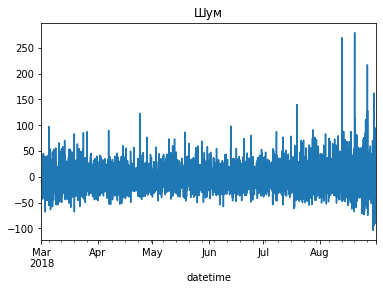

In [26]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(title='Тренд')
plt.show()
decomposed.seasonal[data.iloc[[0]].index.values[0]:data.iloc[[100]].index.values[0]].plot(title='Сезонность')
plt.show()
decomposed.resid.plot(title='Шум')
plt.show()


In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [8]:
make_features(data, 168, 3)

## Обучение

In [9]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [10]:
result = []

**Модель линейной регрессии**

In [11]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
prediction_train_lr = model_lr.predict(features_train)

In [12]:
result_lr = np.sqrt(mean_squared_error(target_train, prediction_train_lr))

In [13]:
result.append(['LinearRegression', result_lr, ''])

**Модель CatBoostRegressor**

In [14]:
def model_cb(l_r, it):
    model = CatBoostRegressor(learning_rate=l_r, iterations=it, random_state=12345, verbose=0)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(estimator=model, cv=tscv, X=features_train, y=target_train, scoring='neg_mean_squared_error')
    return 'CatBoostRegressor', np.sqrt(-np.average(scores)), f'learning_rate:{l_r}, iterations:{it}'

In [15]:
for l_r in [0.3, 0.6, 0.9]:
    for it in [10, 50, 70]:
        result.append(list(model_cb(l_r, it)))
        


**Модель LGBMRegressor**

In [16]:
def model_lgbm(m_d, l_r):
    model = LGBMRegressor(max_depth=m_d,  learning_rate=l_r, random_state=12345)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(estimator=model, cv=tscv, X=features_train, y=target_train, scoring='neg_mean_squared_error')
    return 'LGBMRegressor',np.sqrt(-np.average(scores)), f'max_depth:{m_d}, learning_rate:{l_r}'

In [17]:
for m_d in tqdm([10, 40, 60]):
    for l_r in tqdm([0.3, 0.6, 0.9]):
            result.append(list(model_lgbm(m_d, l_r)))

100%|██████████| 3/3 [03:01<00:00, 60.47s/it]


In [18]:
result_table = pd.DataFrame(result, columns=['name_model', 'RMSE', 'parameters'])

In [19]:
result_table.sort_values('RMSE')

,name_model,RMSE,parameters
0,LinearRegression,20.329911,
2,CatBoostRegressor,23.560592,"learning_rate:0.3, iterations:50"
3,CatBoostRegressor,23.739811,"learning_rate:0.3, iterations:70"
1,CatBoostRegressor,24.156785,"learning_rate:0.3, iterations:10"
16,LGBMRegressor,24.360128,"max_depth:60, learning_rate:0.3"
13,LGBMRegressor,24.360128,"max_depth:40, learning_rate:0.3"
10,LGBMRegressor,24.548013,"max_depth:10, learning_rate:0.3"
4,CatBoostRegressor,25.217193,"learning_rate:0.6, iterations:10"
5,CatBoostRegressor,26.121874,"learning_rate:0.6, iterations:50"
6,CatBoostRegressor,26.402127,"learning_rate:0.6, iterations:70"


**Лучшей моделью оказалась модель LinearRegression**

## Тестирование

In [20]:
model_test =  LinearRegression()
model_test.fit(features_train, target_train)
prediction_test = model_test.predict(features_test)
result_test = np.sqrt(mean_squared_error(target_test, prediction_test))
print('RMSE лучшей модели на тестовой выборке:', result_test)

RMSE лучшей модели на тестовой выборке: 35.503516969373194
